In [136]:
# Dataset Used - https://www.kaggle.com/ibrahimserouis99/one-piece-image-classifier

import numpy as np

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import pathlib
from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import pandas as pd

import seaborn as sns

In [125]:
File_Directory = os.listdir('Data/Train')
Data_Directory = Path('Data')

Images = []
Labels = []
Location = []

iterator = 0

for Folder in File_Directory:
    Category = os.listdir('Data/Train/' + Folder)
    Location.append('Data/Train/' + Folder)
    for Pictures in Category:
        Images.append(Location[iterator] + '/' + Pictures)
        Labels.append(Folder)
    iterator += 1
        
Images = pd.Series(Images, name = 'Images').astype(str)
Labels = pd.Series(Labels, name = 'Labels')
        
Data_Frame = pd.concat([Images, Labels], axis = 1)

print(Data_Frame['Labels'].value_counts())

Nami       665
Zoro       659
Brook      657
Luffy      654
Franky     651
Sanji      651
Chopper    648
Usopp      648
Jinbei     640
Robin      624
Name: Labels, dtype: int64


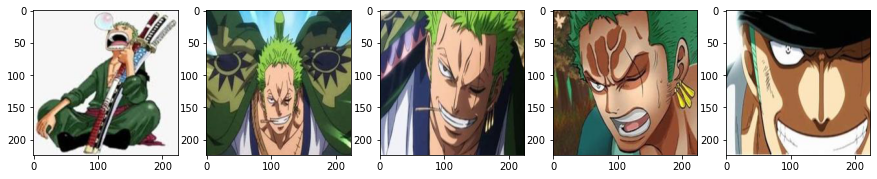

In [126]:
Zoro = list(Data_Directory.glob("Train/Zoro/*.jpg"))

plt.figure(figsize=(15, 15))

for Iterator in range(5):
    plt.subplot(1, 5, Iterator + 1)
    Img = Image.open(str(Zoro[Iterator]))
    plt.imshow(Img)
    plt.axis("on")
    
plt.show()

In [127]:
Train_Data, Test_Data = train_test_split(Data_Frame, test_size = 0.1, shuffle = True, random_state = 1)

In [128]:
Train_Generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = 
                                                                  tf.keras.applications.mobilenet_v2.preprocess_input, 
                                                                  validation_split = 0.2)

Test_Generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function = 
                                                                 tf.keras.applications.mobilenet_v2.preprocess_input)

In [129]:
Train = Train_Generator.flow_from_dataframe(dataframe = Train_Data, x_col = 'Images', y_col = 'Labels', color_mode = 'rgb', 
                                            class_mode = 'categorical', batch_size = 32, shuffle = True, seed = 25, 
                                            subset = 'training')

Valid = Train_Generator.flow_from_dataframe(dataframe = Train_Data, x_col = 'Images', y_col = 'Labels', color_mode = 'rgb',
                                           class_mode = 'categorical', batch_size = 32, shuffle = True, seed = 25, 
                                           subset = 'validation')

Test = Test_Generator.flow_from_dataframe(dataframe = Test_Data, x_col = 'Images', y_col = 'Labels', color_mode = 'rgb',
                                    class_mode = 'categorical', batch_size = 32, shuffle = False)

Found 4678 validated image filenames belonging to 10 classes.
Found 1169 validated image filenames belonging to 10 classes.
Found 650 validated image filenames belonging to 10 classes.


In [130]:
Transfer_Model = tf.keras.applications.MobileNetV2(input_shape = (224, 224, 3), include_top = False, weights = 'imagenet', 
                                                   pooling = 'avg')
Transfer_Model.trainable = False 

In [131]:
Inputs = Transfer_Model.input

X = tf.keras.layers.Dense(128, activation = 'relu')(Transfer_Model.output)
X = layers.Dropout(0.5)(X)
X = tf.keras.layers.Dense(32, activation = 'relu')(X)
Outputs = tf.keras.layers.Dense(10, activation = 'softmax')(X)

My_Model = tf.keras.Model(inputs= Inputs, outputs = Outputs)

In [132]:
My_Model.compile(optimizer = 'adam', loss = 'categorical_crossentropy', metrics = [ 'acc' ])

History = My_Model.fit(Train, validation_data = Valid, epochs = 15, callbacks = 
                       [tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3, restore_best_weights = True)])


Epoch 1/15
147/147 [==============================] - 42s 272ms/step - loss: 1.8571 - acc: 0.3487 - val_loss: 1.2874 - val_acc: 0.6074
Epoch 2/15
147/147 [==============================] - 39s 266ms/step - loss: 1.2277 - acc: 0.5840 - val_loss: 0.9360 - val_acc: 0.6929
Epoch 3/15
147/147 [==============================] - 39s 264ms/step - loss: 0.9613 - acc: 0.6789 - val_loss: 0.7885 - val_acc: 0.7365
Epoch 4/15
147/147 [==============================] - 39s 266ms/step - loss: 0.7825 - acc: 0.7371 - val_loss: 0.7249 - val_acc: 0.7579
Epoch 5/15
147/147 [==============================] - 39s 267ms/step - loss: 0.7017 - acc: 0.7629 - val_loss: 0.6755 - val_acc: 0.7784
Epoch 6/15
147/147 [==============================] - 39s 268ms/step - loss: 0.5991 - acc: 0.7986 - val_loss: 0.6796 - val_acc: 0.7502
Epoch 7/15
147/147 [==============================] - 39s 266ms/step - loss: 0.5564 - acc: 0.8117 - val_loss: 0.6252 - val_acc: 0.7861
Epoch 8/15
147/147 [==============================] - 3

In [133]:
AT_Curve = np.array(History.history['acc'])
LT_Curve = np.array(History.history['loss'])
AV_Curve = np.array(History.history['val_acc'])
LV_Curve = np.array(History.history['val_loss'])

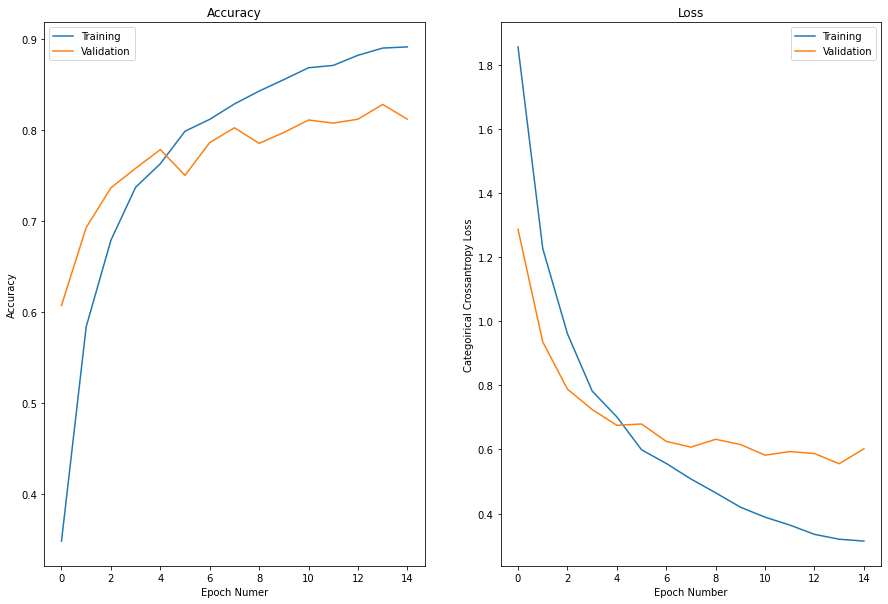

In [134]:
def plot_curve(Accuracy_Train, Loss_Train, Accuracy_Val, Loss_Val):

    Epochs = np.arange(Loss_Train.shape[0])

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, Accuracy_Train, Epochs, Accuracy_Val)
    plt.xlabel('Epoch Numer')
    plt.ylabel('Accuracy')
    plt.title('Accuracy')
    plt.legend(['Training', 'Validation'])

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, Loss_Train, Epochs, Loss_Val)
    plt.xlabel('Epoch Number')
    plt.ylabel('Categoirical Crossantropy Loss')
    plt.title('Loss')
    plt.legend(['Training', 'Validation'])

plt.figure(figsize = [15,10])

plot_curve(AT_Curve, LT_Curve, AV_Curve, LV_Curve)

Test Image Accuracy: 85.69231033325195


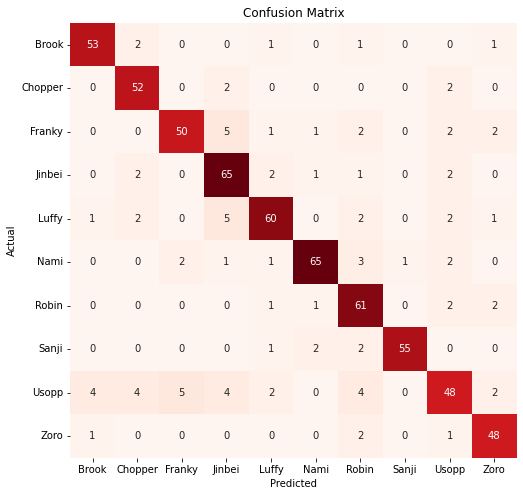

In [135]:
Results = My_Model.evaluate(Test, verbose = 0)
print("Test Image Accuracy: " + str(Results[1] * 100)) 

Predictions = np.argmax(My_Model.predict(Test), axis = 1)
Categories = list(Test.class_indices.keys())

Confusion = confusion_matrix(Test.labels, Predictions, labels = np.arange(10))

plt.figure(figsize = (8, 8))
sns.heatmap(Confusion, annot = True, fmt = 'g', vmin = 0, cmap = 'Reds', cbar = False)
plt.xticks(ticks = np.arange(10) + 0.5, labels = Categories, rotation = 0)
plt.yticks(ticks = np.arange(10) + 0.5, labels = Categories, rotation = 0)

plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

plt.show()